# Setup

To complete the following guide you will need to install the following packages:

1. pandas
2. matplotlib
3. sklearn
4. numpy
5. dspy-ai

You will also need either of these 2:

### Option 1 (Direct Anthropic access)
1. Anthropic API Key

### Option 2 (Access Anthropic via AWS Bedrock)
This is what I have used in this notebook. (I have some AWS credits, which basically makes it more economic for me to use AWS Bedrock)

1. AWS creds and access to Bedrock Claude 3 Haiku. To setup AWS credentials, use [this](https://wellarchitectedlabs.com/common/documentation/aws_credentials/#cli) guide.  

In [50]:
!pip3 install pandas
!pip3 install numpy
!pip3 install dspy-ai
!pip3 install scikit-learn
!pip3 install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Direct Anthropic Setup

In [1]:
!pip3 install anthropic

import os
import dspy

os.environ['ANTHROPIC_API_KEY'] = "ANTHROPIC KEY HERE"

# Setup our environment
import anthropic
import os

client = anthropic.Anthropic(
    # This is the default and can be omitted
    api_key=os.getenv("ANTHROPIC_API_KEY"),
)
dspy.settings.configure(lm=client)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### AWS Bedrock setup

In [29]:
!pip3 install boto3

import dspy
import random

# Does backoff by 3, 9, 27, 60 seconds.
def exponential_backoff(attempts):
    return min(3**attempts, 60)

bedrock_claude = dspy.AWSAnthropic(
    aws_provider = dspy.Bedrock(region_name="us-east-1", profile_name="stage"),
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0.0,
    max_tokens=4096
)
dspy.settings.configure(backoff_time=exponential_backoff)
dspy.settings.configure(lm=bedrock_claude)
print(dspy.settings.lm.kwargs)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
{'model': 'anthropic.claude-3-haiku-20240307-v1:0', 'temperature': 0.0, 'max_tokens': 4096, 'top_p': 1, 'frequency_penalty': 0, 'presence_penalty': 0, 'n': 1, 'anthropic_version': 'bedrock-2023-05-31'}


## Problem Definition: Insurance Support Ticket Classifier

This is a DSPy guide for classification, but I have not generated my own data set. Infact, the problem statement is not my own either. 

Anthropic has a few [cookbooks](https://github.com/anthropics/anthropic-cookbook/blob/main/skills/README.md). One such cookbook is for classification, where they have shared an example of how you can use Anthropic Claude to classify text into a given set of labels. [Classification cookbook](https://github.com/anthropics/anthropic-cookbook/blob/main/skills/classification/guide.ipynb) 

I will be piggybacking on their dataset and their problem statement. This is not meant to make my life easier, I could also use an LLM to generate synthetic data. This has been done, so that we can look side by side at the difference between using Claude directly vs with DSPy. 

Note: To ensure that the comparison is just, we are using the same Claude version as mentioned in the cookbook (Claude 3 Haiku)

In [30]:
import pandas as pd
train_df = pd.read_csv('./data/train.tsv', sep='\t')
print(len(train_df))

test_df = pd.read_csv('./data/test.tsv', sep='\t')
print(len(test_df))

68
68


### Setting up a basic DSPy signature



In [31]:
import dspy
from typing_extensions import Literal
from dspy.functional import TypedChainOfThought

class Classify(dspy.Signature):
    """Classify a text into one of the given options"""

    text = dspy.InputField()
        
    answer: Literal['Billing Inquiries','Policy Administration','Claims Assistance','Coverage Explanations','Quotes and Proposals','Account Management','Billing Disputes','Claims Disputes','Policy Comparisons','General Inquiries'] = dspy.OutputField(desc="Only one word. From the given list")

class GetLabel(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_label = dspy.TypedChainOfThought(Classify)
    
    def forward(
            self,
            text
    ):
        label = self.generate_label(text = text)
        
        return label
    
classifier = GetLabel()

In [32]:
# Create a dataset
training_dataset = []
for i, row in train_df.iterrows():
    example = dspy.Example(text = row['text'], answer=row['label'])
    training_dataset.append(example.with_inputs('text'))

testing_dataset = []
for i, row in test_df.iterrows():
    example = dspy.Example(text = row['text'], answer=row['label'])
    testing_dataset.append(example.with_inputs('text'))

labels = list(set(train_df['label'].unique()))

In [33]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def eval(classifier, dataset):
    llm_preds = []
    true_labels = []
    for data_point in tqdm(dataset, total=len(dataset)):
        llm_preds.append(
            classifier(**data_point.inputs()).answer
        )
        true_labels.append(data_point.answer)
    print("Classification report")
    print(classification_report(true_labels, llm_preds))
    print("Confusion Matrix")
    cm = confusion_matrix(true_labels, llm_preds)
    plot_confusion_matrix(cm,labels)

100%|██████████| 68/68 [02:28<00:00,  2.18s/it]
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Classification report
                       precision    recall  f1-score   support

   Account Management       1.00      0.50      0.67         6
     Billing Disputes       1.00      0.33      0.50         9
    Billing Inquiries       0.36      0.83      0.50         6
    Claims Assistance       0.86      1.00      0.92         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.35      0.89      0.50         9
    General Inquiries       0.00      0.00      0.00         7
Policy Administration       0.83      0.83      0.83         6
   Policy Comparisons       0.00      0.00      0.00         5
 Quotes and Proposals       1.00      0.60      0.75         5

             accuracy                           0.62        68
            macro avg       0.64      0.60      0.57        68
         weighted avg       0.65      0.62      0.58        68

Confusion Matrix


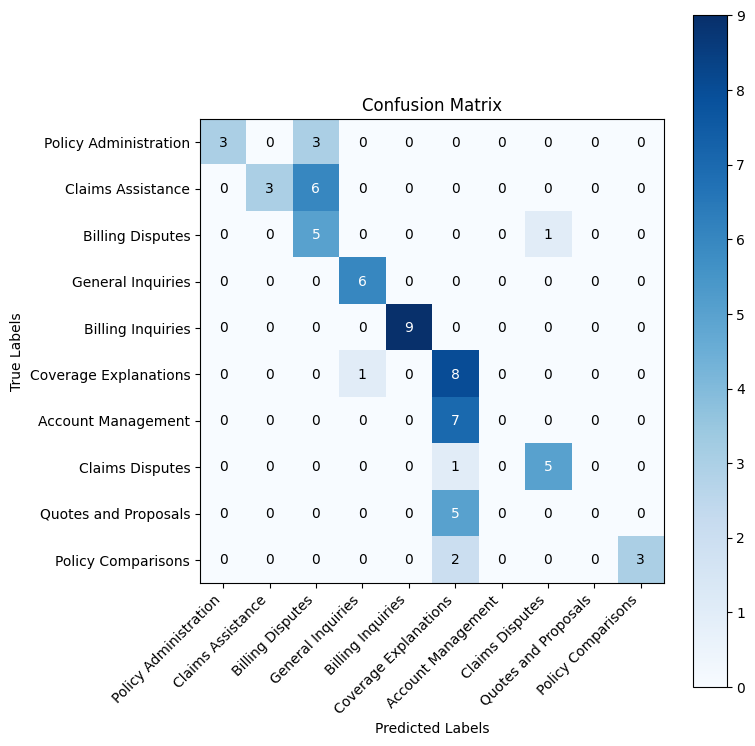

In [34]:
eval(classifier, testing_dataset)

In [35]:
class ClassifyV2(dspy.Signature):
    """Classify a text into one of the given options:
    
    1. Billing Inquiries: Questions about invoices, charges, fees, and premiums; Requests for clarification on billing statements; Inquiries about payment methods and due dates
    2. Policy Administration: Requests for policy changes, updates, or cancellations; Questions about policy renewals and reinstatements; Inquiries about adding or removing coverage options
    3. Claims Assistance: Questions about the claims process and filing procedures; Requests for help with submitting claim documentation; Inquiries about claim status and payout timelines
    4. Coverage Explanations: Questions about what is covered under specific policy types; Requests for clarification on coverage limits and exclusions; Inquiries about deductibles and out-of-pocket expenses
    5. Quotes and Proposals: Requests for new policy quotes and price comparisons; Questions about available discounts and bundling options; Inquiries about switching from another insurer
    6. Account Management: Requests for login credentials or password resets; Questions about online account features and functionality; Inquiries about updating contact or personal information
    7. Billing Disputes: Complaints about unexpected or incorrect charges; Requests for refunds or premium adjustments; Inquiries about late fees or collection notices
    8. Claims Disputes: Complaints about denied or underpaid claims; Requests for reconsideration of claim decisions; Inquiries about appealing a claim outcome
    9. Policy Comparisons: Questions about the differences between policy options; Requests for help deciding between coverage levels; Inquiries about how policies compare to competitors' offerings
    10. General Inquiries: Questions about company contact information or hours of operation; Requests for general information about products or services; Inquiries that don't fit neatly into other categories
    
    """

    text = dspy.InputField()
        
    answer: Literal['Billing Inquiries','Policy Administration','Claims Assistance','Coverage Explanations','Quotes and Proposals','Account Management','Billing Disputes','Claims Disputes','Policy Comparisons','General Inquiries'] = dspy.OutputField(desc="Only one word. From the given list")

class GetLabelV2(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_label = dspy.TypedChainOfThought(ClassifyV2)
    
    def forward(
            self,
            text
    ):
        label = self.generate_label(text = text)
        
        return label
    
classifier = GetLabelV2()

100%|██████████| 68/68 [02:06<00:00,  1.86s/it]
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Classification report
                       precision    recall  f1-score   support

   Account Management       1.00      1.00      1.00         6
     Billing Disputes       0.83      0.56      0.67         9
    Billing Inquiries       0.57      0.67      0.62         6
    Claims Assistance       1.00      1.00      1.00         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.53      1.00      0.69         9
    General Inquiries       0.00      0.00      0.00         7
Policy Administration       0.57      0.67      0.62         6
   Policy Comparisons       0.71      1.00      0.83         5
 Quotes and Proposals       1.00      0.60      0.75         5

             accuracy                           0.75        68
            macro avg       0.72      0.75      0.72        68
         weighted avg       0.72      0.75      0.71        68

Confusion Matrix


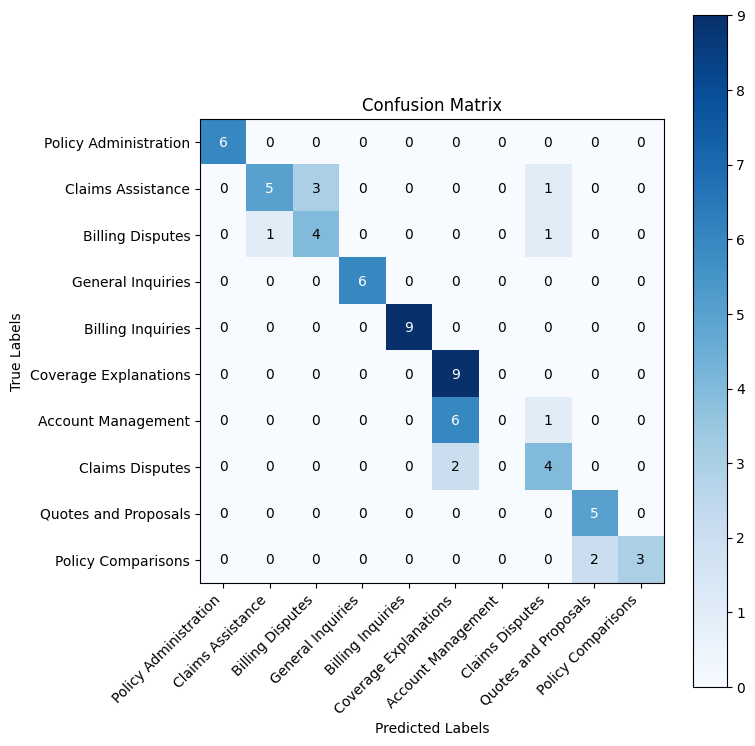

In [36]:
eval(classifier, testing_dataset)

In [40]:
# MIPRO optimisation
from dspy.teleprompt import MIPRO

from dspy.teleprompt import BootstrapFewShotWithRandomSearch
bootstrap_optimizer = BootstrapFewShotWithRandomSearch(
    max_bootstrapped_demos=5,
    max_labeled_demos=5,
    num_candidate_programs=7,
    num_threads=5,
    metric=dspy.evaluate.answer_exact_match,
    teacher_settings=dict(lm=bedrock_claude))

compiled_classifier = bootstrap_optimizer.compile(classifier, trainset=training_dataset[:40], valset=training_dataset[40:65])

Going to sample between 1 and 5 traces per predictor.
Will attempt to bootstrap 7 candidate sets.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Score: 80.0 for set: [0]
New best sscore: 80.0 for seed -3
Scores so far: [80.0]
Best score: 80.0


Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Score: 68.0 for set: [5]
Scores so far: [80.0, 68.0]
Best score: 80.0


 12%|█▎        | 5/40 [00:09<01:08,  1.96s/it]


Bootstrapped 5 full traces after 6 examples in round 0.


Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Score: 88.0 for set: [5]
New best sscore: 88.0 for seed -1
Scores so far: [80.0, 68.0, 88.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


 12%|█▎        | 5/40 [00:09<01:05,  1.88s/it]


Bootstrapped 4 full traces after 6 examples in round 0.


Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


Score: 88.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


  5%|▌         | 2/40 [00:04<01:26,  2.28s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 19.0 / 25  (76.0): 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Score: 76.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


  5%|▌         | 2/40 [00:03<01:09,  1.84s/it]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Score: 88.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0, 88.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


  5%|▌         | 2/40 [00:03<01:11,  1.89s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


Score: 68.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0, 88.0, 68.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


 18%|█▊        | 7/40 [00:13<01:02,  1.90s/it]


Bootstrapped 2 full traces after 8 examples in round 0.


Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Score: 88.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0, 88.0, 68.0, 88.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


 15%|█▌        | 6/40 [00:11<01:07,  2.00s/it]


Bootstrapped 5 full traces after 7 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Score: 76.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0, 88.0, 68.0, 88.0, 76.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88


 20%|██        | 8/40 [00:13<00:54,  1.71s/it]


Bootstrapped 5 full traces after 9 examples in round 0.


Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]

Score: 88.0 for set: [5]
Scores so far: [80.0, 68.0, 88.0, 88.0, 76.0, 88.0, 68.0, 88.0, 76.0, 88.0]
Best score: 88.0
Average of max per entry across top 1 scores: 0.88
Average of max per entry across top 2 scores: 0.88
Average of max per entry across top 3 scores: 0.88
Average of max per entry across top 5 scores: 0.88
Average of max per entry across top 8 scores: 0.88
Average of max per entry across top 9999 scores: 0.88
10 candidate programs found.


In [41]:
compiled_classifier.save('bootstrap_fewshot_v1_basic.json');

[('generate_label.predictor', Predict(StringSignature(text -> reasoning, answer
    instructions="Classify a text into one of the given options:\n\n1. Billing Inquiries: Questions about invoices, charges, fees, and premiums; Requests for clarification on billing statements; Inquiries about payment methods and due dates\n2. Policy Administration: Requests for policy changes, updates, or cancellations; Questions about policy renewals and reinstatements; Inquiries about adding or removing coverage options\n3. Claims Assistance: Questions about the claims process and filing procedures; Requests for help with submitting claim documentation; Inquiries about claim status and payout timelines\n4. Coverage Explanations: Questions about what is covered under specific policy types; Requests for clarification on coverage limits and exclusions; Inquiries about deductibles and out-of-pocket expenses\n5. Quotes and Proposals: Requests for new policy quotes and price comparisons; Questions about avail

100%|██████████| 68/68 [02:30<00:00,  2.21s/it]
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Classification report
                       precision    recall  f1-score   support

   Account Management       1.00      1.00      1.00         6
     Billing Disputes       1.00      1.00      1.00         9
    Billing Inquiries       1.00      1.00      1.00         6
    Claims Assistance       1.00      1.00      1.00         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.60      1.00      0.75         9
    General Inquiries       0.00      0.00      0.00         7
Policy Administration       0.86      1.00      0.92         6
   Policy Comparisons       0.71      1.00      0.83         5
 Quotes and Proposals       1.00      0.60      0.75         5

             accuracy                           0.87        68
            macro avg       0.82      0.86      0.83        68
         weighted avg       0.81      0.87      0.83        68

Confusion Matrix


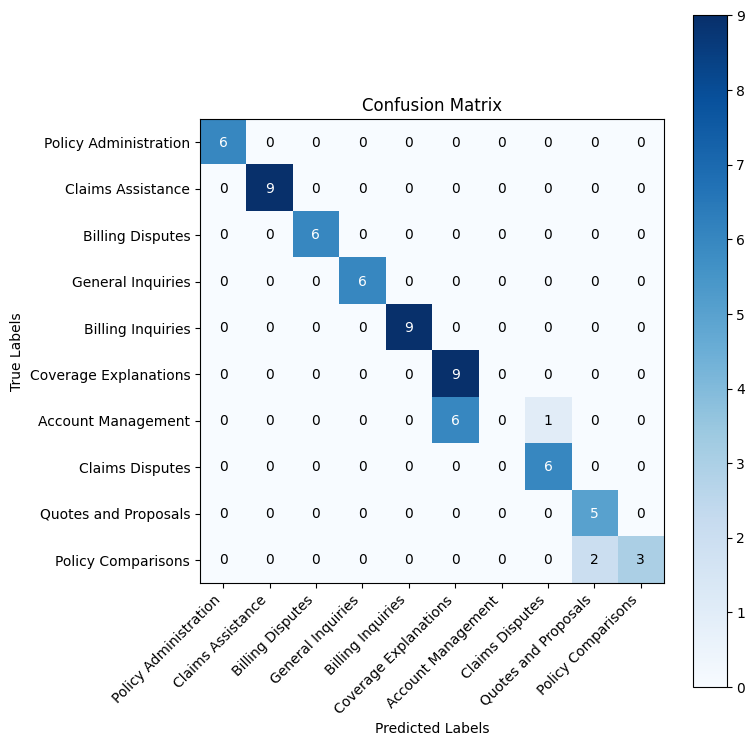

In [42]:
eval(compiled_classifier, testing_dataset)